# Evaluation of a DSB model

## designs masks

In [1]:
from evaluation.mask import get_mni_mask, get_pathology_mask
import matplotlib.pyplot as plt
import torch

In [2]:
mni_mask, mask_transform = get_mni_mask(img_size=128)
mask_ad = get_pathology_mask('AD')
mask_out_ad = mni_mask - mask_ad
slice_idx = 64

/lustre/fswork/projects/rech/krk/usy14zi/diffusion_models/medical_imaging_diffusion/evaluation/mask.py:26: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask_nii = resample_to_img(mask_nii, ref_image, interpolation='nearest', copy_header=True)


In [3]:
print(mni_mask.shape)
print(mask_ad.shape)

torch.Size([1, 169, 208, 179])
torch.Size([1, 169, 208, 179])


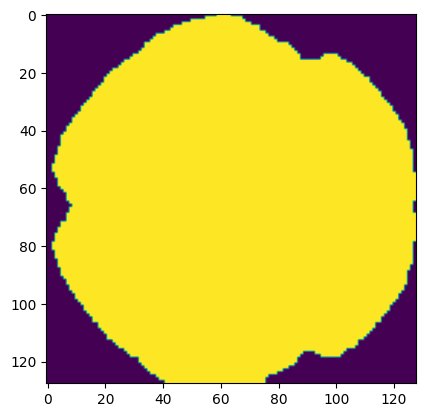

In [4]:
mni_slice = mask_transform(mni_mask[:,:,:,slice_idx]).squeeze()
plt.imshow(mni_slice.numpy())

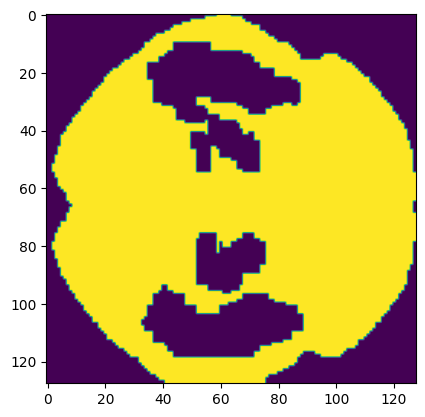

In [6]:
ad_slice = mask_transform(mask_out_ad[:,:,:,slice_idx]).squeeze()
plt.imshow(ad_slice.numpy())

In [31]:
from skimage.metrics import structural_similarity as ssim

ssim_val, ssim_map = ssim(a, a*0.5, data_range=2, full=True)
print(ssim_val)
ssim_map.mean(where=a.astype(bool))

0.8170029530959948


0.77810144

## metrics

In [1]:
from pathlib import Path
import numpy as np
import pandas as pd

import torch
from torchvision import transforms
from torch.utils.data import DataLoader

from diffusion.dsb import DiffusionSchrodingerBridge
from image_datasets.capsSlicesADNI import get_ADNI_datasets, get_dataset_val_hypo
from evaluation import compute_metrics
from evaluation.visualisation import *
from evaluation.mask import get_mni_mask, get_pathology_mask
from utils.config import *

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
task = "ADNI_AD_CN"
#task = "ADNI_hypo"
num = 49

if 15<=num<25 or 31<=num<35 or 40<=num<50:
    img_size = 32
elif 6<=num<15 or 25<=num<31 or 53<=num<56 or num==51:
    img_size = 128
else:
    img_size = 64

print('image size:', img_size)

image size: 32


In [3]:
dataset_val = get_dataset_val_hypo(
    img_size=img_size,
    percentage=30
)
val_dl = DataLoader(
    dataset_val,
    batch_size=64,
)

expe_dir = Path(f"experiments/{task}/dsb{num}")

dsb_param = dsb_config_from_toml(expe_dir / "config.toml")
datasets = get_ADNI_datasets(task, img_size=img_size)

dsb = DiffusionSchrodingerBridge(
    experiment_directory = expe_dir,
    dsb_params = dsb_param,
    datasets = datasets,
    transfer = True,
    evaluation = True,
)
dsb.device

'cuda'

## Compute metrics

In [4]:
n_ipf = 10
num_iter = 20000
fb = 'b'

tsv_1, tsv_2 = compute_metrics(dsb, val_dl, n_ipf, num_iter, img_size, fb)

/gpfslocalsup/pub/anaconda-py3/2023.09/envs/pytorch-gpu-2.3.0+py3.11.5/lib/python3.11/site-packages/paramiko/transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated and will be removed in a future release
  "class": algorithms.Blowfish,


In [5]:
#tsv_1 = "experiments/ADNI_AD_CN/dsb49/evaluation/validation/metrics_b_9_20000.tsv"
#tsv_2 = "experiments/ADNI_AD_CN/dsb49/evaluation/validation/healthiness_b_9_20000.tsv"
df = pd.read_csv(tsv_1, sep="\t")
df

,participant_id,session_id,slice_id,metric,image_X,value
0,sub-ADNI002S5256,ses-M000,54,MSE,input,0.003313
1,sub-ADNI002S5256,ses-M000,54,SSIM,input,0.903883
2,sub-ADNI002S5256,ses-M000,54,PSNR,input,24.798408
3,sub-ADNI002S5256,ses-M000,54,MSE,ground_truth,0.003111
4,sub-ADNI002S5256,ses-M000,54,SSIM,ground_truth,0.913581
...,...,...,...,...,...,...
2995,sub-ADNI941S1195,ses-M000,73,SSIM,input,0.893199
2996,sub-ADNI941S1195,ses-M000,73,PSNR,input,23.342019
2997,sub-ADNI941S1195,ses-M000,73,MSE,ground_truth,0.003236
2998,sub-ADNI941S1195,ses-M000,73,SSIM,ground_truth,0.925884


In [6]:
df_ssim = df[df['metric']=='SSIM']
print(df_ssim[df_ssim['image_X']=='input'].value.mean())
print(df_ssim[df_ssim['image_X']=='ground_truth'].value.mean())

0.8864579674005508
0.9220456956624985


In [7]:
sns.boxplot(df_ssim, x='value', y='image_X')
plt.show()

In [10]:
df_part = df.groupby(["participant_id", "image_X", "metric"]).value.mean().reset_index()
df_m = df_part.groupby(["image_X", "metric"]).agg({'value':['mean','std']}).reset_index()

metrics = ["MSE", "SSIM", "PSNR"]

lines = ["input", "ground_truth"]

print("\\begin{table}[!htb]\n\\caption{}\n\\centering\n")
print("\\begin{tabular}{l|ccc|ccc}")
for line in lines:
    df_line = df_m[df_m["image_X"]==line]
    for metric in metrics:
        df_met = df_line[df_line["metric"]==metric]

        mean = df_met.value["mean"].values[0]
        std = df_met.value["std"].values[0]

        if metric == 'MSE':
            mean = mean*1000
            std = std*1000

        line = line + f"\t& ${mean:.2f} \pm {std:.2f}$"
    print(line)
print("\end{tabular}")
print("\\label{tab:rs_results}\n\end{table}")

\begin{table}[!htb]
\caption{}
\centering

\begin{tabular}{l|ccc|ccc}
input	& $4.45 \pm 0.43$	& $0.89 \pm 0.02$	& $23.56 \pm 0.42$
ground_truth	& $3.54 \pm 0.42$	& $0.92 \pm 0.02$	& $24.60 \pm 0.54$
\end{tabular}
\label{tab:rs_results}
\end{table}


### Make latex table

In [8]:
num = 54
n_ipf = 6
num_iter = 5000
fb = 'b'
expe_ad_cn = Path(f"experiments/ADNI_AD_CN/dsb{num}")
expe_hypo = Path(f"experiments/ADNI_hypo/dsb{num}")

tsv1 = expe_ad_cn / "evaluation" / "validation" / f"metrics_{fb}_{n_ipf}_{num_iter}.tsv"
tsv2 = expe_hypo / "evaluation" / "validation" / f"metrics_{fb}_{n_ipf}_{num_iter}.tsv"

df1 = pd.read_csv(tsv1, sep="\t")
df2 = pd.read_csv(tsv2, sep="\t")

<class 'FileNotFoundError'>: [Errno 2] No such file or directory: 'experiments/ADNI_hypo/dsb54/evaluation/validation/metrics_b_6_5000.tsv'

In [ ]:
df_part1 = df1.groupby(["participant_id", "image_X", "metric"]).value.mean().reset_index()
df_m1 = df_part1.groupby(["image_X", "metric"]).agg({'value':['mean','std']}).reset_index()

df_part2 = df2.groupby(["participant_id", "image_X", "metric"]).value.mean().reset_index()
df_m2 = df_part2.groupby(["image_X", "metric"]).agg({'value':['mean','std']}).reset_index()

df_m1['task'] = 'AD_CN'
df_m2['task'] = 'hypo'

dff = pd.concat([df_m1, df_m2])
dff

In [ ]:
tasks = ["AD_CN", "hypo"]
metrics = ["MSE", "SSIM", "PSNR"]

lines = ["input", "ground_truth"]

print("\\begin{table}[!htb]\n\\caption{}\n\\centering\n")
print("\\begin{tabular}{l|ccc|ccc}")
for line in lines:
    df_line = dff[dff["image_X"]==line]
    for task in tasks:
        df_task = df_line[df_line["task"]==task]
        for metric in metrics:
            df_met = df_task[df_task["metric"]==metric]

            mean = df_met.value["mean"].values[0]
            std = df_met.value["std"].values[0]

            if metric == 'MSE':
                mean = mean*1000
                std = std*1000

            line = line + f"\t& ${mean:.2f} \pm {std:.2f}$"
    print(line)
print("\end{tabular}")
print("\\label{tab:rs_results}\n\end{table}")

### Make table healthiness

In [ ]:
# Made a plot instead

## Make residual plots

In [6]:
n_ipf = 10
num_iter = 20000
fb = 'b'

dsb.load_checkpoints(n_ipf, num_iter, fb=fb)

In [10]:
ad_mask, ad_mask_transform = get_pathology_mask(pathology='AD', img_size=32)
ad_mask_slice = -0.3*ad_mask_transform(ad_mask[:,:,:,64]).squeeze().numpy()
#plt.imshow(np.rot90(-0.3*ad_mask_slice), cmap='seismic', vmin=-1, vmax=1)

In [14]:
batch = next(iter(val_dl))
image = batch['image'][10].unsqueeze(dim=0)
slice_id =  batch['slice_id'][10].item()

samples = dsb.sample_batch(image, fb)

mni_mask, mask_transform = get_mni_mask(img_size)
mask_mni_slice = mask_transform(mni_mask[:,:,:,slice_id]).squeeze()

ad_mask, ad_mask_transform = get_pathology_mask(pathology='AD', img_size=img_size)
ad_mask_slice = -0.3*ad_mask_transform(ad_mask[:,:,:,slice_id]).squeeze().numpy()

norm01 = transforms.Compose([
    transforms.Lambda(lambda t: 0.5*(t+1))
])

In [15]:
plot_dir = expe_dir / "evaluation"
plot_dir.mkdir(parents=True, exist_ok=True)
X = norm01(image.squeeze().cpu()) * mask_mni_slice
Y = norm01(samples[0][-1].squeeze().cpu()) * mask_mni_slice
Gt = norm01(batch['label'][10].squeeze().cpu()) * mask_mni_slice
make_diff_plot(X, Y, Gt, ad_mask_slice, plot_file = plot_dir / f"diff_plot_{fb}.pdf")

In [75]:
from skimage.metrics import structural_similarity as ssim
#x = image.squeeze().cpu().numpy()
#y = samples[0][-1].squeeze().cpu().numpy()
#gt = batch['label'][10].squeeze().cpu().numpy()
ssim_val, ssim_map = ssim(
    norm01(image.squeeze().cpu().numpy()),
    norm01(samples[0][-1].squeeze().cpu().numpy()),
    data_range=1, full=True
)
print(ssim_map.mean(where=mask_mni_slice.numpy().astype(bool)))
#print(ssim(Gt.numpy(), Y.numpy(), data_range=2, full=True))

0.8399016


## Make trajectory plots

In [76]:
plot_dir = expe_dir / "evaluation"
plot_dir.mkdir(parents=True, exist_ok=True)
make_traj_plot(
    norm01(image).squeeze().cpu(),
    norm01(samples[0]),
    mask = mask_mni_slice,
    plot_file = plot_dir / f"trajectory_{fb}.pdf",
)

## Make plot healthiness

In [ ]:
#num = 49
expe_ad_cn = Path(f"experiments/ADNI_AD_CN/dsb{num}")
expe_hypo = Path(f"experiments/ADNI_hypo/dsb{num}")

tsv1 = expe_ad_cn / "evaluation" / "validation" / f"healthiness_{fb}_{n_ipf}_{num_iter}.tsv"
tsv2 = expe_hypo / "evaluation" / "validation" / f"healthiness_{fb}_{n_ipf}_{num_iter}.tsv"

df1 = pd.read_csv(tsv1, sep="\t")
df2 = pd.read_csv(tsv2, sep="\t")

In [ ]:
df_plot1 = df1.groupby(["participant_id", "image"])["healthiness"].mean().reset_index()
df_plot2 = df2.groupby(["participant_id", "image"])["healthiness"].mean().reset_index()

df_plot1["task"] = "AD_CN"
df_plot2["task"] = "hypo"
df_plot = pd.concat([df_plot1, df_plot2])

In [ ]:
fig = plt.figure(figsize=(10, 2))
plt.grid()
sns.violinplot(df_plot, x="healthiness", y="image", hue="task", inner="quart")
plt.show()
plt.savefig(expe_ad_cn / "evaluation" / f"boxplot_{num}_{fb}_{n_ipf}_{num_iter}.pdf", format="pdf", bbox_inches="tight")

In [ ]:
df_plot

### Make residual plot over iteration

In [6]:
n_ipf = 9
num_iter = 20000
fb = 'b'

def mse_in_mask(X, Y, mask):
    return ((X - Y)**2).mean(where=mask.astype(bool))

plot_dir = expe_dir / "evaluation" / "iterations"
plot_dir.mkdir(parents=True, exist_ok=True)

norm01 = transforms.Compose([
    transforms.Lambda(lambda t: 0.5*(t+1))
])

batch = next(iter(val_dl))
image = batch['image'][10].unsqueeze(dim=0)
slice_id =  batch['slice_id'][10].item()

mni_mask, mask_transform = get_mni_mask(img_size)
mask_mni_slice = mask_transform(mni_mask[:,:,:,slice_id]).squeeze().numpy()

ad_mask = get_pathology_mask(pathology='AD')
ad_mask_slice = mask_transform(ad_mask[:,:,:,slice_id]).squeeze().numpy()
plt.imshow(np.rot90(-0.3*ad_mask_slice), cmap='seismic', vmin=-1, vmax=1)

for it in range(1, n_ipf):
    print(f"========== Iteration {it} ==========")
    dsb.load_checkpoints(it, num_iter, fb=fb)
    
    samples = dsb.sample_batch(image, fb)

    X = norm01(image.squeeze().cpu()).numpy() * mask_mni_slice
    Y = norm01(samples[0][-1].squeeze().cpu()).numpy() * mask_mni_slice
    Gt = norm01(batch['label'][10].squeeze().cpu()).numpy() * mask_mni_slice

    print(f"MSE input-output :\t{mse_in_mask(X, Y, mask_mni_slice)}")
    print(f"MSE ground truth-output :\t{mse_in_mask(Gt, Y, mask_mni_slice)}")
    
    ## PROBLEME DE NORMALIZATION
    print(f"\nMSE mask-residual :\t{mse_in_mask(X - Y, ad_mask_slice, ad_mask_slice)}")

    make_diff_plot(X, Y, Gt, plot_dir / f"residual_{it}.pdf")

========== Iteration 1 ==========
MSE input-output :	0.0020669831428676844
MSE ground truth-output :	0.004287718795239925

MSE mask-residual :	1.0460801124572754
========== Iteration 2 ==========
MSE input-output :	0.00197223830036819
MSE ground truth-output :	0.0032613789662718773

MSE mask-residual :	1.0714927911758423
========== Iteration 3 ==========
MSE input-output :	0.0023155566304922104
MSE ground truth-output :	0.0025115981698036194

MSE mask-residual :	1.0988332033157349
========== Iteration 4 ==========
MSE input-output :	0.0031422716565430164
MSE ground truth-output :	0.0030602077022194862

MSE mask-residual :	1.1079862117767334
========== Iteration 5 ==========
MSE input-output :	0.002781783463433385
MSE ground truth-output :	0.0032464165706187487

MSE mask-residual :	1.0878620147705078
========== Iteration 6 ==========
MSE input-output :	0.0028919540345668793
MSE ground truth-output :	0.0027851855847984552

MSE mask-residual :	1.1071500778198242
========== Iteration 7 ===

In [5]:
slice_id

64

### Make mean AD anomaly

In [ ]:
# Load AD validation
from image_datasets.capsSlicesADNI import get_ADNI_AD_validation
dataset_val_ad = get_ADNI_AD_validation(img_size=img_size)
val_ad_dl = DataLoader(
    dataset_val_ad,
    batch_size=64,
)
# Sample and buffer all residuals
for batch in val_ad_dl:
    samples = dsb.sample_batch(batch['image'], fb)

# Compute mean of the residuals for each slice
# Correlate it with an Altas

## Tests

In [ ]:
dataset_val_hypo, dataset_val_cn = get_ADNI_validation()

val_dl_f = DataLoader(
    dataset_val_hypo,
    batch_size=20,
    shuffle=False,
    #num_workers=8,
    drop_last=True,
)
val_dl_b = DataLoader(
    datasets["val_final"],
    batch_size=64,
    shuffle=False,
    #num_workers=8,
    drop_last=True,
)

In [ ]:
batch = next(iter(val_dl_b))
image = batch['image'][10].unsqueeze(dim=0)
    
samples = dsb.sample_batch(image, 'b')

make_diff_plot(
    img_in = image.squeeze().cpu(),
    img_out = samples[0][-1].squeeze().cpu(),
    img_ref = slice_transformations(tensor_img[:,:,:,64]).squeeze().cpu(),
)

In [13]:
import nibabel as nib
CAPS_ADNI = Path("/lustre/fswork/projects/rech/krk/commun/datasets/adni/caps/caps_pet_uniform_v2025")

a = nib.load(CAPS_ADNI / "masks" / f"mask_hypo_ad_resampled.nii")
a.get_fdata().dtype

dtype('<f8')

In [8]:
import torch
import numpy as np

a = torch.load(
    "/lustre/fswork/projects/rech/krk/commun/datasets/adni/caps/caps_pet_uniform_v2025" \
    "/subjects/sub-ADNI002S0729/ses-M048/deeplearning_prepare_data/image_based/pet_linear" \
    "/sub-ADNI002S0729_ses-M048_trc-18FFDG_rec-coregiso_space-MNI152NLin2009cSym_desc-Crop_res-1x1x1_suvr-cerebellumPons2_pet.pt"
)
a.shape

torch.Size([1, 169, 208, 179])

In [18]:
import nibabel as nib
from nilearn.image import resample_to_img
CAPS_ADNI = Path("/lustre/fswork/projects/rech/krk/commun/datasets/adni/caps/caps_pet_uniform_v2025")

pathologies = ["ad","bvftd","pca","svppa","lvppa","nfvppa"]

ref_img_path = (
    CAPS_ADNI 
    / "subjects"
    / "sub-ADNI002S0729"
    / "ses-M048"
    / "pet_linear"
    / "sub-ADNI002S0729_ses-M048_trc-18FFDG_rec-coregiso_space-MNI152NLin2009cSym_desc-Crop_res-1x1x1_suvr-cerebellumPons2_pet.nii.gz"
)
ref_image = nib.load(ref_img_path)

for p in pathologies:
    mask_path = CAPS_ADNI / "masks" / f"mask_hypo_{p}.nii"
    mask_nii = nib.load(mask_path)
    resampled_mask_nii = resample_to_img(mask_nii, ref_image, interpolation='nearest')
    resampled_mask_nii.to_filename(CAPS_ADNI / "masks" / f"mask_hypo_{p}_resampled.nii")

/tmp/xpython_299575/3818471017.py:20: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask_nii = resample_to_img(mask_nii, ref_image, interpolation='nearest')
/linkhome/rech/genysv01/usy14zi/.local/lib/python3.11/site-packages/nilearn/image/resampling.py:805: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  return resample_img(
/tmp/xpython_299575/3818471017.py:20: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled_mask_nii = resample_to_img(mask_nii, ref_image, interpolation='nearest')
/linkhome/rech/genysv01/usy14zi/.local/lib/python3.11/site-packages/nilearn/image/resampling.py:8

In [19]:
mask_nii = nib.load(CAPS_ADNI / "masks" / f"mask_hypo_ad_resampled.nii")

In [20]:
print(mask_nii.header)

<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : b''
db_name         : b''
extents         : 0
session_error   : 0
regular         : b''
dim_info        : 0
dim             : [  3 169 208 179   1   1   1   1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : float64
bitpix          : 64
slice_start     : 0
pixdim          : [1. 1. 1. 1. 1. 1. 1. 1.]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 0
cal_max         : 0.0
cal_min         : 0.0
slice_duration  : 0.0
toffset         : 0.0
glmax           : 0
glmin           : 0
descrip         : b''
aux_file        : b''
qform_code      : unknown
sform_code      : aligned
quatern_b       : 0.0
quatern_c       : 0.0
quatern_d       : 0.0
qoffset_x       : -84.0
qoffset_y       : -119.0
qoffset_z       : -78.0
srow_x          : [  1.   0.   0. -84.]
srow_y  